In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import ast  # For safely evaluating string representations of tuples

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
import folium
from folium.plugins import HeatMap, MarkerCluster

# Geospatial analysis
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

# Settings for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
%matplotlib inline

In [4]:
# Load the dataset
file_path = 'data/trips_8days_flat.csv'
trips_df = pd.read_csv(file_path)

# Display the first few rows
print(f"Dataset shape: {trips_df.shape}")
trips_df.head()

Dataset shape: (91214, 9)


,bike_id,start_station_id,start_coords,end_station_id,end_coords,start_time,end_time,temperature,rain
0,3480,122,"(46.9613082, 7.4466679)",122,"(46.9613082, 7.4466679)",20240429_160100,20240429_160300,18.54,No rain data available
1,4754,462,"(46.9558281, 7.4529965)",216,"(46.9538192, 7.4581813)",20240429_160001,20240429_160400,18.54,No rain data available
2,9,334,"(46.520202, 6.571784)",9,"(46.519805, 6.579676)",20240429_160001,20240429_160400,18.54,No rain data available
3,5947,21,"(46.521043, 6.573253)",334,"(46.520202, 6.571784)",20240429_160200,20240429_160400,18.54,No rain data available
4,4522,114,"(46.9566007, 7.4402185)",217,"(46.9483305, 7.44079)",20240429_160001,20240429_160400,18.54,No rain data available


## 3. Explore Dataset Structure and Summary Statistics

Let's examine the dataset structure, check for missing values, and compute some basic statistics:

In [5]:
# Check data types
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91214 entries, 0 to 91213
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bike_id           91214 non-null  int64  
 1   start_station_id  91214 non-null  int64  
 2   start_coords      91214 non-null  object 
 3   end_station_id    91214 non-null  int64  
 4   end_coords        91214 non-null  object 
 5   start_time        91214 non-null  object 
 6   end_time          91214 non-null  object 
 7   temperature       91214 non-null  float64
 8   rain              91214 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 6.3+ MB


In [6]:
# Check for missing values
missing_values = trips_df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")

Missing values per column:
No missing values


## 4. Visualize Bike Path Data

We'll visualize the distribution of trip counts, temperatures, and basic spatial plots of start and end points.

/var/folders/l8/x6h41g5n1l58tbdctr84ly4h0000gn/T/ipykernel_3381/430745625.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=station_counts.values, y=station_counts.index, palette='viridis')


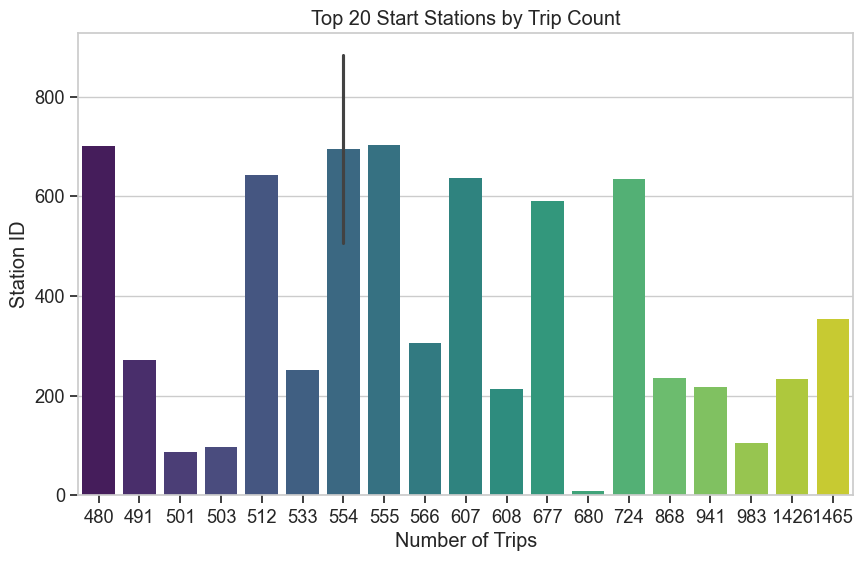

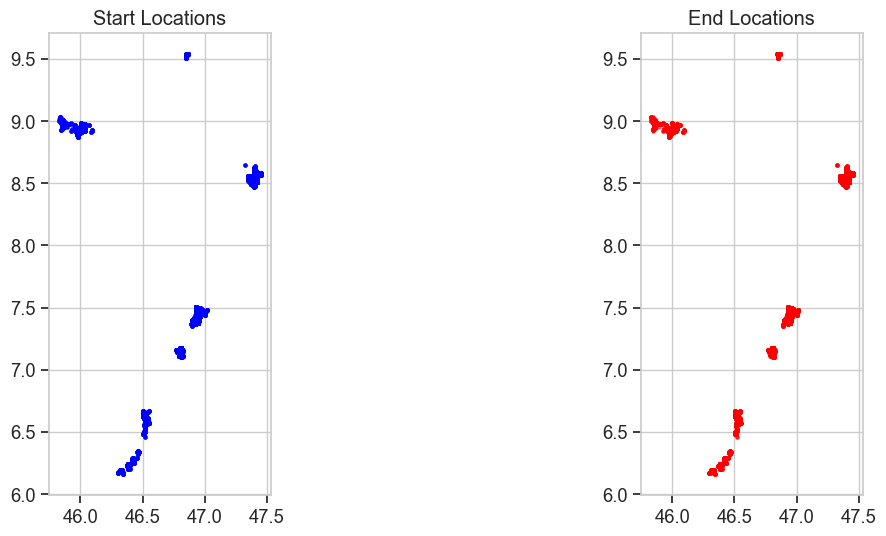

In [7]:
# Distribution of trip counts per start station
station_counts = trips_df['start_station_id'].value_counts().head(20)
plt.figure(figsize=(10,6))
sns.barplot(x=station_counts.values, y=station_counts.index, palette='viridis')
plt.title('Top 20 Start Stations by Trip Count')
plt.xlabel('Number of Trips')
plt.ylabel('Station ID')
plt.show()

# Scatter plot of start and end locations
# Parse coordinates
trips_df['start_point'] = trips_df['start_coords'].apply(lambda x: Point(ast.literal_eval(x)))
trips_df['end_point'] = trips_df['end_coords'].apply(lambda x: Point(ast.literal_eval(x)))
start_gdf = gpd.GeoDataFrame(trips_df, geometry='start_point')
end_gdf = gpd.GeoDataFrame(trips_df, geometry='end_point')

fig, ax = plt.subplots(1, 2, figsize=(14,6))
start_gdf.plot(ax=ax[0], markersize=5, color='blue', alpha=0.5)
ax[0].set_title('Start Locations')
end_gdf.plot(ax=ax[1], markersize=5, color='red', alpha=0.5)
ax[1].set_title('End Locations')
plt.show()

## 5. Analyze Temporal Patterns

Let's explore how bike usage varies over time and parse the timestamp data:

Trip duration statistics:
count    91214.000000
mean        67.706341
std        358.435822
min          1.916667
25%          6.000000
50%          9.983333
75%         17.000000
max      11543.000000
Name: duration_minutes, dtype: float64


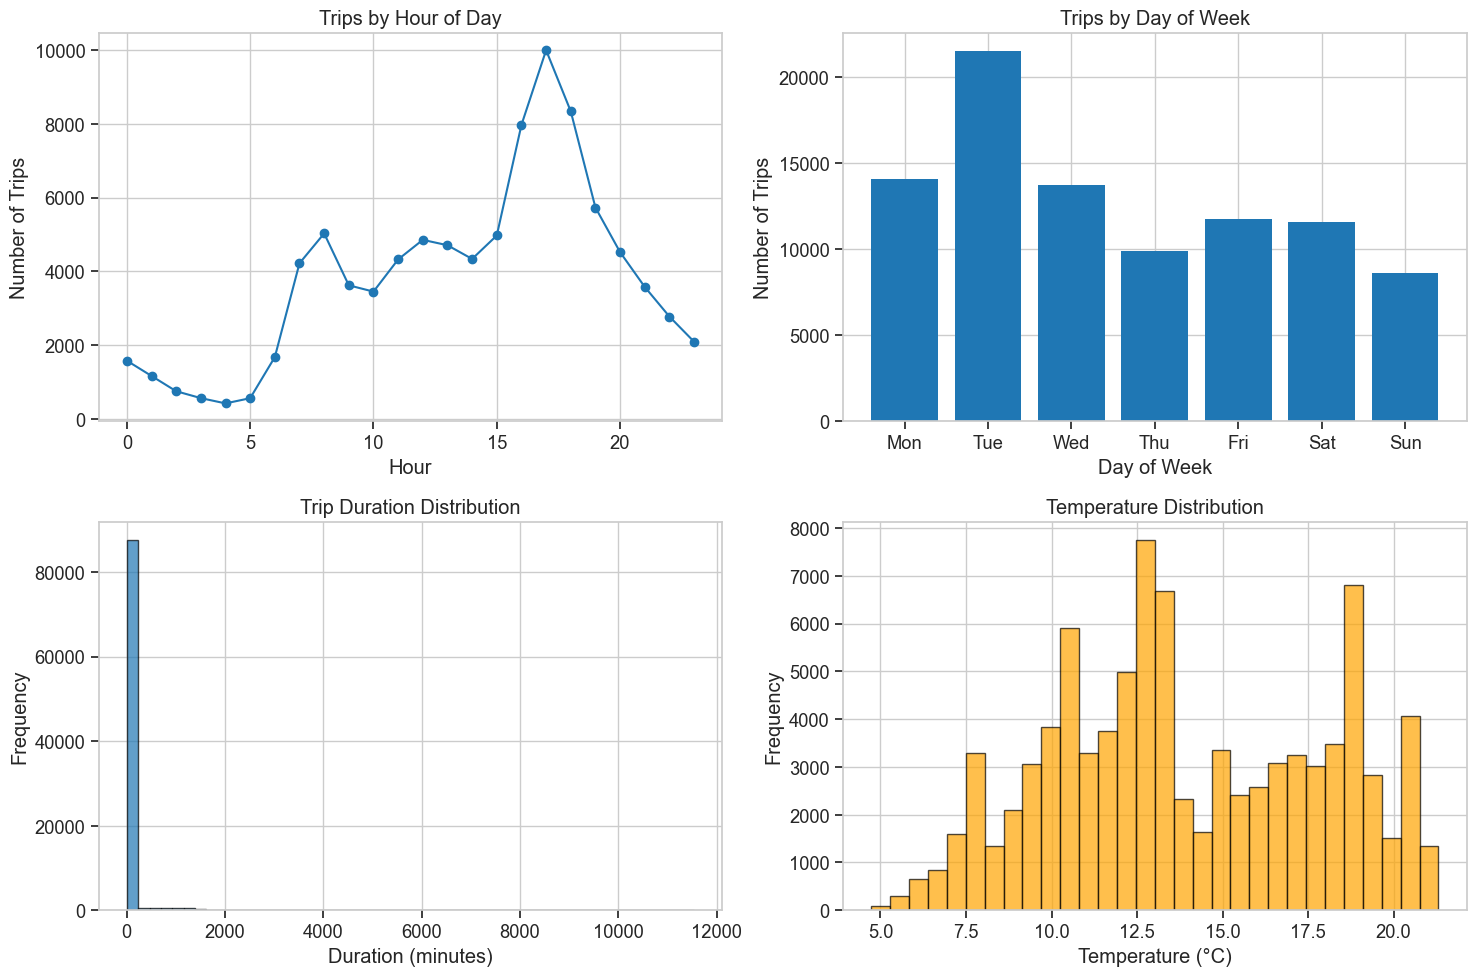

In [8]:
# Parse timestamps
trips_df['start_datetime'] = pd.to_datetime(trips_df['start_time'], format='%Y%m%d_%H%M%S')
trips_df['end_datetime'] = pd.to_datetime(trips_df['end_time'], format='%Y%m%d_%H%M%S')

# Calculate trip duration in minutes
trips_df['duration_minutes'] = (trips_df['end_datetime'] - trips_df['start_datetime']).dt.total_seconds() / 60

# Extract temporal features
trips_df['hour'] = trips_df['start_datetime'].dt.hour
trips_df['day_of_week'] = trips_df['start_datetime'].dt.dayofweek
trips_df['date'] = trips_df['start_datetime'].dt.date

print(f"Trip duration statistics:")
print(trips_df['duration_minutes'].describe())

# Plot hourly distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Hourly distribution
hourly_trips = trips_df['hour'].value_counts().sort_index()
axes[0,0].plot(hourly_trips.index, hourly_trips.values, marker='o')
axes[0,0].set_title('Trips by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Number of Trips')

# Daily distribution
daily_trips = trips_df['day_of_week'].value_counts().sort_index()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,1].bar(range(7), [daily_trips.get(i, 0) for i in range(7)])
axes[0,1].set_title('Trips by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Number of Trips')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(day_names)

# Trip duration distribution
axes[1,0].hist(trips_df['duration_minutes'], bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Trip Duration Distribution')
axes[1,0].set_xlabel('Duration (minutes)')
axes[1,0].set_ylabel('Frequency')

# Temperature distribution
axes[1,1].hist(trips_df['temperature'], bins=30, alpha=0.7, edgecolor='black', color='orange')
axes[1,1].set_title('Temperature Distribution')
axes[1,1].set_xlabel('Temperature (°C)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 6. Analyze Spatial Patterns

Let's create interactive maps to visualize bike station locations and trip flows:

Interactive map saved as 'bike_stations_map.html'


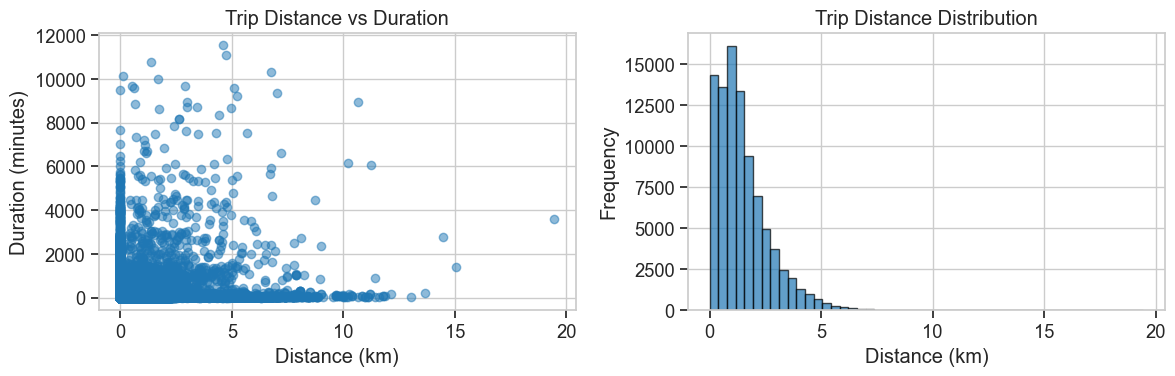

Distance statistics:
count    91214.000000
mean         1.470309
std          1.214680
min          0.000000
25%          0.654610
50%          1.202572
75%          2.019284
max         19.442626
Name: distance_km, dtype: float64


In [ ]:
# Extract coordinates for mapping
trips_df['start_lat'] = trips_df['start_coords'].apply(lambda x: ast.literal_eval(x)[0])
trips_df['start_lon'] = trips_df['start_coords'].apply(lambda x: ast.literal_eval(x)[1])
trips_df['end_lat'] = trips_df['end_coords'].apply(lambda x: ast.literal_eval(x)[0])
trips_df['end_lon'] = trips_df['end_coords'].apply(lambda x: ast.literal_eval(x)[1])

# Calculate trip distances using haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points on Earth"""
    from math import radians, cos, sin, asin, sqrt
    
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lat2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

trips_df['distance_km'] = trips_df.apply(
    lambda row: haversine_distance(row['start_lat'], row['start_lon'], 
                                 row['end_lat'], row['end_lon']), axis=1
)

# Station analysis
start_stations = trips_df.groupby('start_station_id').agg({
    'start_lat': 'first',
    'start_lon': 'first',
    'bike_id': 'count'
}).rename(columns={'bike_id': 'trip_count'}).reset_index()

# Create an interactive map
center_lat = trips_df['start_lat'].mean()
center_lon = trips_df['start_lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add start stations as markers
for idx, station in start_stations.iterrows():
    folium.CircleMarker(
        location=[station['start_lat'], station['start_lon']],
        radius=min(station['trip_count']/10, 20),  # Scale marker size
        popup=f"Station {station['start_station_id']}: {station['trip_count']} trips",
        color='blue',
        fill=True,
        fillColor='lightblue'
    ).add_to(m)

# Save map
m.save('bike_stations_map.html')
print("Interactive map saved as 'bike_stations_map.html'")

# Distance and duration analysis
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(trips_df['distance_km'], trips_df['duration_minutes'], alpha=0.5)
plt.xlabel('Distance (km)')
plt.ylabel('Duration (minutes)')
plt.title('Trip Distance vs Duration')

plt.subplot(1, 2, 2)
plt.hist(trips_df['distance_km'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Trip Distance Distribution')

plt.tight_layout()
plt.show()

print(f"Distance statistics:")
print(trips_df['distance_km'].describe())

In [1]:
# Additional imports for flow-based modeling
import networkx as nx
from collections import defaultdict
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("Flow-based modeling libraries imported successfully!")

Flow-based modeling libraries imported successfully!


## Step 1: Create Flow Network Structure

First, let's create a network representation of the bike sharing system where:
- Nodes = Bike stations
- Edges = Possible routes between stations
- Edge weights = Flow volume (number of trips)

In [4]:
# Load the data first
file_path = 'data/trips_8days_flat.csv'
trips_df = pd.read_csv(file_path)

# Parse timestamps for temporal analysis
trips_df['start_datetime'] = pd.to_datetime(trips_df['start_time'], format='%Y%m%d_%H%M%S')
trips_df['end_datetime'] = pd.to_datetime(trips_df['end_time'], format='%Y%m%d_%H%M%S')
trips_df['hour'] = trips_df['start_datetime'].dt.hour
trips_df['day'] = trips_df['start_datetime'].dt.date

# Extract coordinates
trips_df['start_lat'] = trips_df['start_coords'].apply(lambda x: ast.literal_eval(x)[0])
trips_df['start_lon'] = trips_df['start_coords'].apply(lambda x: ast.literal_eval(x)[1])
trips_df['end_lat'] = trips_df['end_coords'].apply(lambda x: ast.literal_eval(x)[0])
trips_df['end_lon'] = trips_df['end_coords'].apply(lambda x: ast.literal_eval(x)[1])

print(f"Dataset loaded: {len(trips_df)} trips across {len(trips_df['start_station_id'].unique())} stations")
print(f"Time range: {trips_df['start_datetime'].min()} to {trips_df['start_datetime'].max()}")

class BikeFlowNetwork:
    """
    A class to model bike sharing system as a flow network
    """
    
    def __init__(self, trips_df):
        self.trips_df = trips_df
        self.flow_graph = nx.DiGraph()
        self.station_coords = {}
        self.hourly_flows = {}
        self.flow_patterns = {}
        
    def build_station_network(self):
        """Build the basic station network with coordinates"""
        # Get unique stations and their coordinates
        start_stations = self.trips_df.groupby('start_station_id').agg({
            'start_lat': 'first',
            'start_lon': 'first'
        }).reset_index()
        
        end_stations = self.trips_df.groupby('end_station_id').agg({
            'end_lat': 'first',
            'end_lon': 'first'
        }).reset_index()
        
        # Combine and deduplicate stations
        for _, row in start_stations.iterrows():
            station_id = row['start_station_id']
            self.station_coords[station_id] = (row['start_lat'], row['start_lon'])
            self.flow_graph.add_node(station_id, 
                                   lat=row['start_lat'], 
                                   lon=row['start_lon'])
        
        for _, row in end_stations.iterrows():
            station_id = row['end_station_id']
            if station_id not in self.station_coords:
                self.station_coords[station_id] = (row['end_lat'], row['end_lon'])
                self.flow_graph.add_node(station_id, 
                                       lat=row['end_lat'], 
                                       lon=row['end_lon'])
        
        print(f"Built network with {len(self.flow_graph.nodes)} stations")
        
    def compute_hourly_flows(self):
        """Compute flow volumes between stations for each hour"""
        for hour in range(24):
            hour_trips = self.trips_df[self.trips_df['hour'] == hour]
            
            # Count flows between station pairs
            flows = hour_trips.groupby(['start_station_id', 'end_station_id']).size().reset_index(name='flow_count')
            
            self.hourly_flows[hour] = flows
            
            # Add edges to graph with flow volumes
            for _, row in flows.iterrows():
                start_id = row['start_station_id']
                end_id = row['end_station_id']
                flow_count = row['flow_count']
                
                if self.flow_graph.has_edge(start_id, end_id):
                    if f'flow_hour_{hour}' not in self.flow_graph[start_id][end_id]:
                        self.flow_graph[start_id][end_id][f'flow_hour_{hour}'] = 0
                    self.flow_graph[start_id][end_id][f'flow_hour_{hour}'] += flow_count
                else:
                    edge_attrs = {f'flow_hour_{hour}': flow_count}
                    self.flow_graph.add_edge(start_id, end_id, **edge_attrs)
        
        print(f"Computed flows for 24 hours. Total edges: {len(self.flow_graph.edges)}")

# Initialize the flow network
flow_network = BikeFlowNetwork(trips_df)
flow_network.build_station_network()
flow_network.compute_hourly_flows()

# Display some basic network statistics
print(f"\nNetwork Statistics:")
print(f"Nodes (stations): {flow_network.flow_graph.number_of_nodes()}")
print(f"Edges (routes): {flow_network.flow_graph.number_of_edges()}")
print(f"Average degree: {2 * flow_network.flow_graph.number_of_edges() / flow_network.flow_graph.number_of_nodes():.2f}")

# Show sample of hourly flows
sample_hour = 8  # 8 AM
if sample_hour in flow_network.hourly_flows:
    sample_flows = flow_network.hourly_flows[sample_hour].head(10)
    print(f"\nSample flows at {sample_hour}:00:")
    print(sample_flows)

Dataset loaded: 91214 trips across 712 stations
Time range: 2024-04-29 16:00:01 to 2024-05-07 23:16:01
Built network with 714 stations
Computed flows for 24 hours. Total edges: 29471

Network Statistics:
Nodes (stations): 714
Edges (routes): 29471
Average degree: 82.55

Sample flows at 8:00:
   start_station_id  end_station_id  flow_count
0                 6               6           4
1                 6               7           1
2                 6               8           1
3                 6               9           1
4                 6              32           1
5                 6              39           1
6                 6             334           1
7                 6             543           1
8                 8               9           2
9                 8             334           1


## Step 2: Analyze Flow Patterns

Now let's analyze the temporal flow patterns to understand how bike flows change throughout the day.

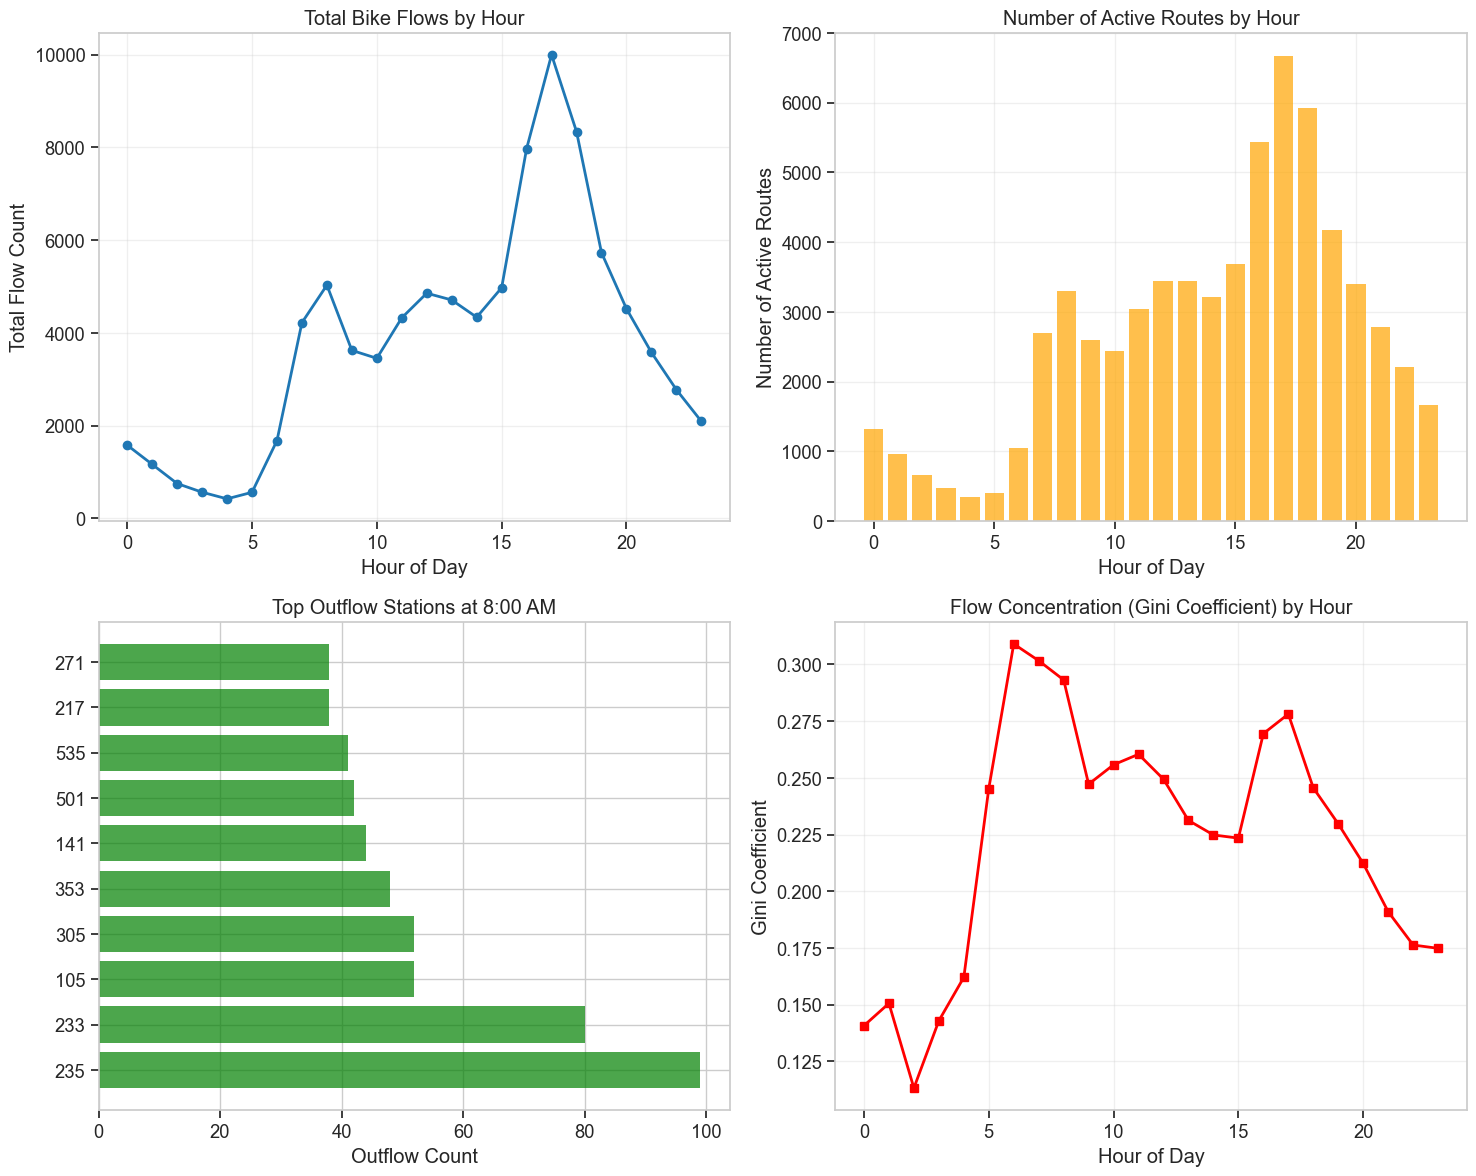

Flow pattern analysis completed:
- Peak flow hour: 17:00 with 9997 trips
- Most active routes hour: 17:00 with 6671 routes
- Highest flow concentration hour: 6:00 (Gini = 0.309)


In [5]:
def analyze_flow_patterns(flow_network):
    """Analyze temporal flow patterns in the network"""
    
    # 1. Compute outflow and inflow for each station by hour
    station_outflows = defaultdict(lambda: defaultdict(int))
    station_inflows = defaultdict(lambda: defaultdict(int))
    
    for hour in range(24):
        if hour in flow_network.hourly_flows:
            flows = flow_network.hourly_flows[hour]
            
            for _, row in flows.iterrows():
                start_station = row['start_station_id']
                end_station = row['end_station_id']
                flow_count = row['flow_count']
                
                station_outflows[start_station][hour] += flow_count
                station_inflows[end_station][hour] += flow_count
    
    # 2. Find dominant flow directions for each hour
    hourly_dominant_flows = {}
    for hour in range(24):
        if hour in flow_network.hourly_flows:
            flows = flow_network.hourly_flows[hour]
            # Get top 20 flows for this hour
            top_flows = flows.nlargest(20, 'flow_count')
            hourly_dominant_flows[hour] = top_flows
    
    # 3. Compute flow centrality - stations that are central to the flow network
    flow_centrality = {}
    for hour in range(24):
        if hour in flow_network.hourly_flows:
            # Create hour-specific graph
            hour_graph = nx.DiGraph()
            flows = flow_network.hourly_flows[hour]
            
            for _, row in flows.iterrows():
                hour_graph.add_edge(row['start_station_id'], row['end_station_id'], 
                                  weight=row['flow_count'])
            
            # Compute centrality measures
            if len(hour_graph.edges) > 0:
                try:
                    betweenness = nx.betweenness_centrality(hour_graph, weight='weight')
                    pagerank = nx.pagerank(hour_graph, weight='weight')
                    flow_centrality[hour] = {'betweenness': betweenness, 'pagerank': pagerank}
                except:
                    flow_centrality[hour] = {'betweenness': {}, 'pagerank': {}}
    
    return station_outflows, station_inflows, hourly_dominant_flows, flow_centrality

# Analyze flow patterns
station_outflows, station_inflows, hourly_dominant_flows, flow_centrality = analyze_flow_patterns(flow_network)

# Visualize hourly flow patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Total hourly flows
hourly_totals = []
for hour in range(24):
    if hour in flow_network.hourly_flows:
        total = flow_network.hourly_flows[hour]['flow_count'].sum()
        hourly_totals.append(total)
    else:
        hourly_totals.append(0)

axes[0,0].plot(range(24), hourly_totals, marker='o', linewidth=2, markersize=6)
axes[0,0].set_title('Total Bike Flows by Hour')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Total Flow Count')
axes[0,0].grid(True, alpha=0.3)

# 2. Number of active routes by hour
active_routes = []
for hour in range(24):
    if hour in flow_network.hourly_flows:
        count = len(flow_network.hourly_flows[hour])
        active_routes.append(count)
    else:
        active_routes.append(0)

axes[0,1].bar(range(24), active_routes, alpha=0.7, color='orange')
axes[0,1].set_title('Number of Active Routes by Hour')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Number of Active Routes')
axes[0,1].grid(True, alpha=0.3)

# 3. Top station outflows (morning rush)
morning_hour = 8
morning_outflows = station_outflows
top_morning_stations = sorted([(station, flows.get(morning_hour, 0)) 
                              for station, flows in morning_outflows.items()], 
                             key=lambda x: x[1], reverse=True)[:10]

stations, outflows = zip(*top_morning_stations)
axes[1,0].barh(range(len(stations)), outflows, alpha=0.7, color='green')
axes[1,0].set_title(f'Top Outflow Stations at {morning_hour}:00 AM')
axes[1,0].set_xlabel('Outflow Count')
axes[1,0].set_yticks(range(len(stations)))
axes[1,0].set_yticklabels(stations)

# 4. Flow concentration by hour (Gini coefficient)
def gini_coefficient(flows):
    """Compute Gini coefficient to measure flow concentration"""
    if len(flows) == 0:
        return 0
    flows = np.array(sorted(flows))
    n = len(flows)
    cumsum = np.cumsum(flows)
    return (2.0 * np.arange(1, n + 1) * flows).sum() / (n * cumsum[-1]) - (n + 1) / n

gini_by_hour = []
for hour in range(24):
    if hour in flow_network.hourly_flows:
        flows = flow_network.hourly_flows[hour]['flow_count'].values
        gini = gini_coefficient(flows)
        gini_by_hour.append(gini)
    else:
        gini_by_hour.append(0)

axes[1,1].plot(range(24), gini_by_hour, marker='s', linewidth=2, markersize=6, color='red')
axes[1,1].set_title('Flow Concentration (Gini Coefficient) by Hour')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Gini Coefficient')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Flow pattern analysis completed:")
print(f"- Peak flow hour: {np.argmax(hourly_totals)}:00 with {max(hourly_totals)} trips")
print(f"- Most active routes hour: {np.argmax(active_routes)}:00 with {max(active_routes)} routes")
print(f"- Highest flow concentration hour: {np.argmax(gini_by_hour)}:00 (Gini = {max(gini_by_hour):.3f})")

## Step 3: Flow-Based Path Prediction Model

Now we'll create a model that predicts the most likely path a bike will take from any station, based on historical flow patterns.

In [6]:
class FlowBasedPathPredictor:
    """
    Predicts bike paths based on historical flow patterns
    """
    
    def __init__(self, flow_network):
        self.flow_network = flow_network
        self.transition_probabilities = {}
        self.flow_models = {}
        
    def compute_transition_probabilities(self):
        """Compute transition probabilities for each station at each hour"""
        
        for hour in range(24):
            self.transition_probabilities[hour] = {}
            
            if hour in self.flow_network.hourly_flows:
                flows = self.flow_network.hourly_flows[hour]
                
                # Group by start station to compute probabilities
                station_flows = flows.groupby('start_station_id')
                
                for start_station, station_data in station_flows:
                    total_outflow = station_data['flow_count'].sum()
                    
                    if total_outflow > 0:
                        # Compute transition probabilities
                        probs = {}
                        for _, row in station_data.iterrows():
                            end_station = row['end_station_id']
                            probability = row['flow_count'] / total_outflow
                            probs[end_station] = probability
                        
                        self.transition_probabilities[hour][start_station] = probs
        
        print(f"Computed transition probabilities for {len(self.transition_probabilities)} hours")
    
    def predict_next_station(self, current_station, hour, method='probabilistic'):
        """
        Predict the next station a bike will visit
        
        Args:
            current_station: Current station ID
            hour: Hour of the day (0-23)
            method: 'probabilistic', 'max_flow', or 'random_walk'
        """
        
        if hour not in self.transition_probabilities:
            return None, 0.0
        
        if current_station not in self.transition_probabilities[hour]:
            return None, 0.0
        
        probs = self.transition_probabilities[hour][current_station]
        
        if method == 'max_flow':
            # Return station with highest flow probability
            next_station = max(probs.items(), key=lambda x: x[1])
            return next_station[0], next_station[1]
        
        elif method == 'probabilistic':
            # Sample based on probabilities
            stations = list(probs.keys())
            probabilities = list(probs.values())
            
            if len(stations) > 0:
                next_station = np.random.choice(stations, p=probabilities)
                return next_station, probs[next_station]
        
        elif method == 'random_walk':
            # Random walk with bias towards high-flow destinations
            stations = list(probs.keys())
            weights = np.array(list(probs.values()))**2  # Square to bias towards high flows
            weights = weights / weights.sum()
            
            if len(stations) > 0:
                next_station = np.random.choice(stations, p=weights)
                return next_station, probs[next_station]
        
        return None, 0.0
    
    def predict_path(self, start_station, hour, max_steps=5, method='probabilistic'):
        """
        Predict a complete path starting from a station
        
        Args:
            start_station: Starting station ID
            hour: Starting hour
            max_steps: Maximum number of steps to predict
            method: Prediction method
        """
        
        path = [start_station]
        current_station = start_station
        current_hour = hour
        probabilities = []
        
        for step in range(max_steps):
            next_station, prob = self.predict_next_station(current_station, current_hour % 24, method)
            
            if next_station is None or prob < 0.01:  # Stop if very low probability
                break
            
            path.append(next_station)
            probabilities.append(prob)
            current_station = next_station
            
            # Update hour (assuming each step is 1 hour, can be modified)
            current_hour = (current_hour + 1) % 24
            
            # Avoid cycles (basic)
            if len(path) > 2 and next_station in path[:-1]:
                break
        
        return path, probabilities
    
    def evaluate_predictions(self, test_trips, method='max_flow'):
        """Evaluate prediction accuracy on test data"""
        
        correct_predictions = 0
        total_predictions = 0
        
        for _, trip in test_trips.iterrows():
            start_station = trip['start_station_id']
            end_station = trip['end_station_id']
            hour = trip['hour']
            
            predicted_station, prob = self.predict_next_station(start_station, hour, method)
            
            if predicted_station is not None:
                total_predictions += 1
                if predicted_station == end_station:
                    correct_predictions += 1
        
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        return accuracy, correct_predictions, total_predictions

# Initialize and train the predictor
predictor = FlowBasedPathPredictor(flow_network)
predictor.compute_transition_probabilities()

# Test the predictor with some examples
test_stations = list(flow_network.station_coords.keys())[:5]
test_hours = [8, 12, 17, 20]  # Different hours

print("=== Flow-Based Path Predictions ===\n")

for station in test_stations:
    print(f"Predictions from Station {station}:")
    
    for hour in test_hours:
        path, probs = predictor.predict_path(station, hour, max_steps=3, method='max_flow')
        
        if len(path) > 1:
            print(f"  {hour}:00 - Path: {' → '.join(map(str, path))}")
            print(f"         Probabilities: {[f'{p:.3f}' for p in probs]}")
        else:
            print(f"  {hour}:00 - No significant flows from this station")
    
    print()

# Evaluate on recent data (last day)
last_day_trips = trips_df[trips_df['day'] == trips_df['day'].max()].head(1000)  # Sample for faster evaluation

print("=== Model Evaluation ===")
for method in ['max_flow', 'probabilistic']:
    accuracy, correct, total = predictor.evaluate_predictions(last_day_trips, method=method)
    print(f"{method.title()} method: {accuracy:.3f} accuracy ({correct}/{total} correct predictions)")

Computed transition probabilities for 24 hours
=== Flow-Based Path Predictions ===

Predictions from Station 6.0:
  8:00 - Path: 6.0 → 6 → 6
         Probabilities: ['0.364', '0.217']
  12:00 - Path: 6.0 → 6 → 6
         Probabilities: ['0.366', '0.219']
  17:00 - Path: 6.0 → 6 → 33 → 543
         Probabilities: ['0.314', '0.125', '0.333']
  20:00 - Path: 6.0 → 9 → 9
         Probabilities: ['0.400', '0.188']

Predictions from Station 7.0:
  8:00 - No significant flows from this station
  12:00 - Path: 7.0 → 7 → 21 → 26
         Probabilities: ['0.250', '0.500', '0.227']
  17:00 - Path: 7.0 → 9 → 9
         Probabilities: ['0.385', '0.294']
  20:00 - Path: 7.0 → 7 → 7
         Probabilities: ['0.286', '0.400']

Predictions from Station 8.0:
  8:00 - Path: 8.0 → 9 → 9
         Probabilities: ['0.667', '0.391']
  12:00 - Path: 8.0 → 8 → 8
         Probabilities: ['0.429', '0.353']
  17:00 - Path: 8.0 → 9 → 9
         Probabilities: ['0.238', '0.294']
  20:00 - Path: 8.0 → 334 → 9 → 9
   

## Step 4: Advanced Flow Prediction with Machine Learning

Let's enhance our model by incorporating weather, temporal features, and machine learning to predict flow intensities.

In [8]:
class AdvancedFlowPredictor:
    """
    Advanced flow predictor using machine learning features
    """
    
    def __init__(self, trips_df, flow_network):
        self.trips_df = trips_df
        self.flow_network = flow_network
        self.models = {}
        self.scalers = {}
        self.station_features = {}
        
    def engineer_features(self):
        """Create features for flow prediction"""
        
        # Compute station-level features
        for station_id in self.flow_network.station_coords.keys():
            features = {}
            
            # Basic station statistics
            station_trips = self.trips_df[
                (self.trips_df['start_station_id'] == station_id) | 
                (self.trips_df['end_station_id'] == station_id)
            ]
            
            features['total_trips'] = len(station_trips)
            features['avg_temperature'] = station_trips['temperature'].mean() if len(station_trips) > 0 else 20.0
            features['lat'] = self.flow_network.station_coords[station_id][0]
            features['lon'] = self.flow_network.station_coords[station_id][1]
            
            # Temporal patterns
            for hour in range(24):
                hour_trips_start = len(station_trips[
                    (station_trips['start_station_id'] == station_id) & 
                    (station_trips['hour'] == hour)
                ])
                hour_trips_end = len(station_trips[
                    (station_trips['end_station_id'] == station_id) & 
                    (station_trips['hour'] == hour)
                ])
                
                features[f'outflow_hour_{hour}'] = hour_trips_start
                features[f'inflow_hour_{hour}'] = hour_trips_end
            
            # Network centrality (simplified)
            neighbors = len(list(self.flow_network.flow_graph.neighbors(station_id)))
            predecessors = len(list(self.flow_network.flow_graph.predecessors(station_id)))
            features['out_degree'] = neighbors
            features['in_degree'] = predecessors
            
            self.station_features[station_id] = features
        
        print(f"Engineered features for {len(self.station_features)} stations")
    
    def prepare_flow_training_data(self):
        """Prepare training data for flow prediction"""
        
        training_data = []
        
        for hour in range(24):
            if hour in self.flow_network.hourly_flows:
                flows = self.flow_network.hourly_flows[hour]
                
                for _, row in flows.iterrows():
                    start_station = row['start_station_id']
                    end_station = row['end_station_id']
                    flow_count = row['flow_count']
                    
                    if start_station in self.station_features and end_station in self.station_features:
                        # Create feature vector
                        feature_vector = []
                        
                        # Temporal features
                        feature_vector.extend([
                            hour,
                            np.sin(2 * np.pi * hour / 24),  # Cyclical hour
                            np.cos(2 * np.pi * hour / 24)
                        ])
                        
                        # Start station features
                        start_features = self.station_features[start_station]
                        feature_vector.extend([
                            start_features['lat'],
                            start_features['lon'],
                            start_features['total_trips'],
                            start_features[f'outflow_hour_{hour}'],
                            start_features['out_degree']
                        ])
                        
                        # End station features
                        end_features = self.station_features[end_station]
                        feature_vector.extend([
                            end_features['lat'],
                            end_features['lon'],
                            end_features['total_trips'],
                            end_features[f'inflow_hour_{hour}'],
                            end_features['in_degree']
                        ])
                        
                        # Distance between stations
                        distance = np.sqrt(
                            (start_features['lat'] - end_features['lat'])**2 + 
                            (start_features['lon'] - end_features['lon'])**2
                        )
                        feature_vector.append(distance)
                        
                        # Weather (simplified - using average)
                        avg_temp = (start_features['avg_temperature'] + end_features['avg_temperature']) / 2
                        feature_vector.append(avg_temp)
                        
                        training_data.append(feature_vector + [flow_count])
        
        # Convert to numpy array
        training_data = np.array(training_data)
        X = training_data[:, :-1]
        y = training_data[:, -1]
        
        print(f"Prepared training data: {X.shape[0]} samples, {X.shape[1]} features")
        return X, y
    
    def train_flow_model(self):
        """Train machine learning model to predict flows"""
        
        X, y = self.prepare_flow_training_data()
        
        # Split data
        split_idx = int(0.8 * len(X))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Scale features
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train Random Forest model
        self.model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        self.model.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = self.model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        print(f"Flow prediction model trained:")
        print(f"  MAE: {mae:.3f}")
        print(f"  RMSE: {np.sqrt(mse):.3f}")
        print(f"  Feature importances (top 5):")
        
        # Show top feature importances
        feature_names = ['hour', 'sin_hour', 'cos_hour', 
                        'start_lat', 'start_lon', 'start_trips', 'start_outflow', 'start_degree',
                        'end_lat', 'end_lon', 'end_trips', 'end_inflow', 'end_degree',
                        'distance', 'temperature']
        
        importances = self.model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]
        
        for i in range(5):
            idx = sorted_idx[i]
            print(f"    {feature_names[idx]}: {importances[idx]:.3f}")
        
        return mae, np.sqrt(mse)
    
    def predict_station_flows(self, station_id, hour, top_k=5):
        """Predict top-k destinations from a station at a given hour"""
        
        if station_id not in self.station_features:
            return []
        
        predictions = []
        start_features = self.station_features[station_id]
        
        # Test all possible destinations
        for end_station in self.station_features.keys():
            if end_station == station_id:  # Skip self-loops
                continue
            
            end_features = self.station_features[end_station]
            
            # Create feature vector
            feature_vector = [
                hour,
                np.sin(2 * np.pi * hour / 24),
                np.cos(2 * np.pi * hour / 24),
                start_features['lat'],
                start_features['lon'],
                start_features['total_trips'],
                start_features[f'outflow_hour_{hour}'],
                start_features['out_degree'],
                end_features['lat'],
                end_features['lon'],
                end_features['total_trips'],
                end_features[f'inflow_hour_{hour}'],
                end_features['in_degree'],
                np.sqrt((start_features['lat'] - end_features['lat'])**2 + 
                       (start_features['lon'] - end_features['lon'])**2),
                (start_features['avg_temperature'] + end_features['avg_temperature']) / 2
            ]
            
            # Predict flow
            X_pred = self.scaler.transform([feature_vector])
            predicted_flow = self.model.predict(X_pred)[0]
            
            predictions.append((end_station, predicted_flow))
        
        # Sort by predicted flow and return top-k
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:top_k]

# Initialize and train advanced predictor
advanced_predictor = AdvancedFlowPredictor(trips_df, flow_network)
advanced_predictor.engineer_features()
mae, rmse = advanced_predictor.train_flow_model()

print("\n=== Advanced Flow Predictions ===\n")

# Test predictions for sample stations
sample_stations = list(flow_network.station_coords.keys())[:3]

for station in sample_stations:
    print(f"Top destinations from Station {station}:")
    
    for hour in [8, 17]:  # Morning and evening
        predictions = advanced_predictor.predict_station_flows(station, hour, top_k=3)
        
        print(f"  {hour}:00 - Top destinations:")
        for i, (dest_station, predicted_flow) in enumerate(predictions):
            print(f"    {i+1}. Station {dest_station}: {predicted_flow:.1f} predicted trips")
    
    print()

Engineered features for 714 stations
Prepared training data: 65337 samples, 15 features
Flow prediction model trained:
  MAE: 0.415
  RMSE: 0.670
  Feature importances (top 5):
    start_outflow: 0.147
    end_inflow: 0.146
    distance: 0.101
    start_degree: 0.079
    temperature: 0.076

=== Advanced Flow Predictions ===

Top destinations from Station 6.0:
  8:00 - Top destinations:
    1. Station 235.0: 3.5 predicted trips
    2. Station 890.0: 3.5 predicted trips
    3. Station 171.0: 3.2 predicted trips
  17:00 - Top destinations:
    1. Station 165.0: 12.0 predicted trips
    2. Station 514.0: 11.7 predicted trips
    3. Station 233.0: 7.9 predicted trips

Top destinations from Station 7.0:
  8:00 - Top destinations:
    1. Station 235.0: 1.8 predicted trips
    2. Station 233.0: 1.4 predicted trips
    3. Station 563.0: 1.4 predicted trips
  17:00 - Top destinations:
    1. Station 9.0: 4.1 predicted trips
    2. Station 233.0: 3.3 predicted trips
    3. Station 598.0: 3.1 pred

## Step 5: Visualize Flow-Based Predictions

Let's create interactive visualizations to show the predicted bike flows and paths.

Flow prediction maps saved:
- flow_predictions_morning.html
- flow_predictions_evening.html


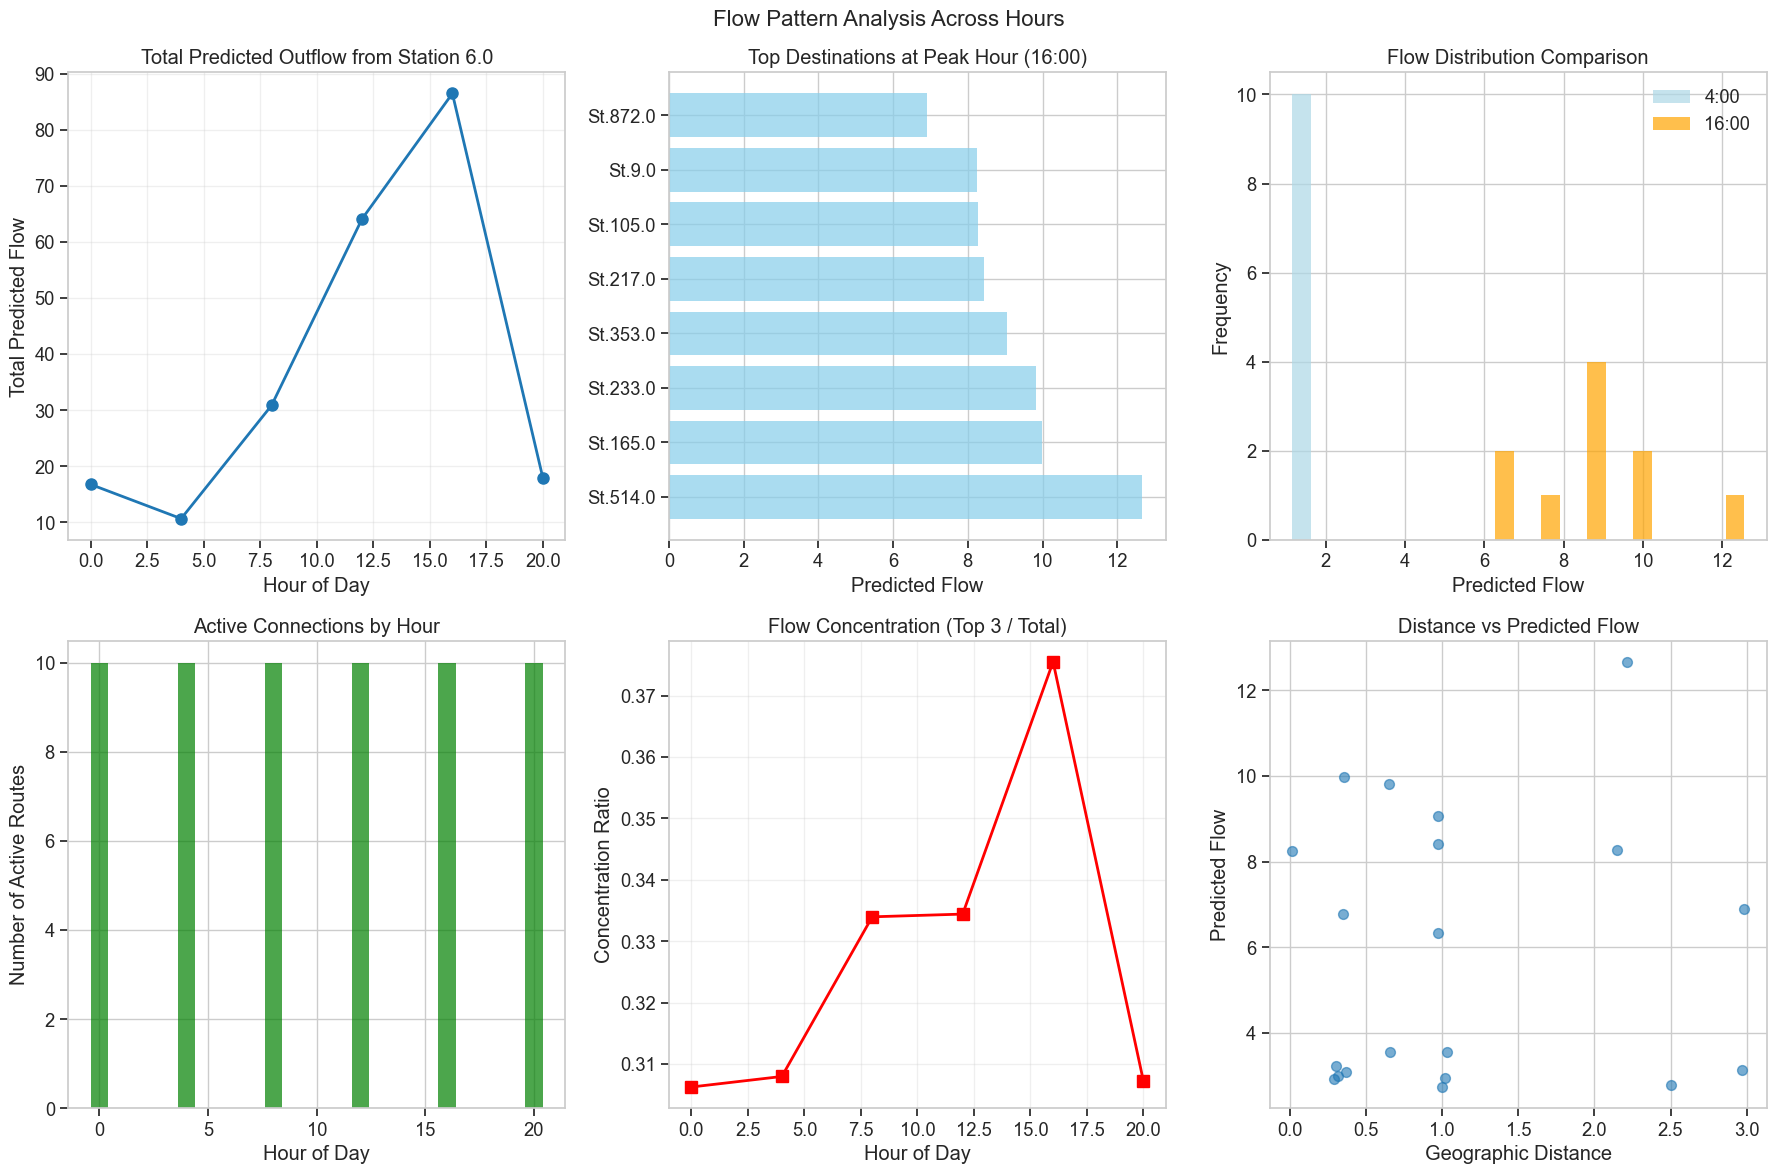


Flow Analysis Summary for Station 6.0:
Peak flow hour: 16:00 with 86.5 total predicted trips
Most connected hour: 0:00 with 10 active routes
Highest concentration hour: 16:00 with 0.376 concentration ratio


In [10]:
def visualize_flow_predictions(flow_network, predictor, advanced_predictor, hour=8):
    """Create interactive map showing flow predictions"""
    
    # Get center coordinates
    all_coords = list(flow_network.station_coords.values())
    center_lat = np.mean([coord[0] for coord in all_coords])
    center_lon = np.mean([coord[1] for coord in all_coords])
    
    # Create base map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Add stations as markers
    station_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred',
                     'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white',
                     'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
    
    # Sample stations for visualization
    sample_stations = list(flow_network.station_coords.keys())[:20]
    
    for i, station_id in enumerate(sample_stations):
        lat, lon = flow_network.station_coords[station_id]
        color = station_colors[i % len(station_colors)]
        
        # Get predicted destinations
        predictions = advanced_predictor.predict_station_flows(station_id, hour, top_k=3)
        
        # Create popup with predictions
        popup_text = f"Station {station_id}<br>Hour: {hour}:00<br><br>Top destinations:<br>"
        for j, (dest_station, flow) in enumerate(predictions[:3]):
            popup_text += f"{j+1}. Station {dest_station}: {flow:.1f} trips<br>"
        
        folium.Marker(
            location=[lat, lon],
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=f"Station {station_id}",
            icon=folium.Icon(color=color, icon='bicycle', prefix='fa')
        ).add_to(m)
        
        # Add flow arrows to top destinations
        for j, (dest_station, flow) in enumerate(predictions[:2]):  # Show top 2
            if dest_station in flow_network.station_coords:
                dest_lat, dest_lon = flow_network.station_coords[dest_station]
                
                # Flow line thickness based on predicted flow
                weight = max(2, min(10, flow / 2))
                
                folium.PolyLine(
                    locations=[[lat, lon], [dest_lat, dest_lon]],
                    color=color,
                    weight=weight,
                    opacity=0.7,
                    popup=f"Flow: {flow:.1f} trips"
                ).add_to(m)
    
    # Add legend
    legend_html = f'''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>Flow Predictions - {hour}:00</h4>
    <p><i class="fa fa-bicycle" style="color:red"></i> Bike Stations</p>
    <p>Line thickness = Flow intensity</p>
    <p>Click stations for detailed predictions</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Create flow prediction map for morning rush hour
morning_map = visualize_flow_predictions(flow_network, predictor, advanced_predictor, hour=8)
morning_map.save('flow_predictions_morning.html')

# Create flow prediction map for evening rush hour
evening_map = visualize_flow_predictions(flow_network, predictor, advanced_predictor, hour=17)
evening_map.save('flow_predictions_evening.html')

print("Flow prediction maps saved:")
print("- flow_predictions_morning.html")
print("- flow_predictions_evening.html")

# Analyze flow patterns across different hours
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Flow Pattern Analysis Across Hours', fontsize=16)

# Select a central station for analysis
central_station = list(flow_network.station_coords.keys())[0]

# Analyze flows from central station across hours
hourly_predictions = {}
for hour in range(0, 24, 4):  # Every 4 hours
    predictions = advanced_predictor.predict_station_flows(central_station, hour, top_k=10)
    hourly_predictions[hour] = predictions

# Plot 1: Flow intensity by hour from central station
hours = list(hourly_predictions.keys())
total_flows = [sum([flow for _, flow in hourly_predictions[hour]]) for hour in hours]

axes[0,0].plot(hours, total_flows, marker='o', linewidth=2, markersize=8)
axes[0,0].set_title(f'Total Predicted Outflow from Station {central_station}')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Total Predicted Flow')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Top destinations at peak hour
peak_hour = hours[np.argmax(total_flows)]
peak_predictions = hourly_predictions[peak_hour][:8]
destinations = [f'St.{dest}' for dest, _ in peak_predictions]
flows = [flow for _, flow in peak_predictions]

axes[0,1].barh(destinations, flows, alpha=0.7, color='skyblue')
axes[0,1].set_title(f'Top Destinations at Peak Hour ({peak_hour}:00)')
axes[0,1].set_xlabel('Predicted Flow')

# Plot 3: Flow distribution comparison
low_hour = 4
high_hour = 16
if low_hour in hourly_predictions and high_hour in hourly_predictions:
    low_flows = [flow for _, flow in hourly_predictions[low_hour]]
    high_flows = [flow for _, flow in hourly_predictions[high_hour]]

    axes[0,2].hist([low_flows, high_flows], bins=10, alpha=0.7, 
                   label=[f'{low_hour}:00', f'{high_hour}:00'], color=['lightblue', 'orange'])
    axes[0,2].set_title('Flow Distribution Comparison')
    axes[0,2].set_xlabel('Predicted Flow')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].legend()

# Plot 4: Network connectivity by hour
connectivity_by_hour = []
for hour in hours:
    predictions = hourly_predictions[hour]
    active_connections = len([flow for _, flow in predictions if flow > 1.0])
    connectivity_by_hour.append(active_connections)

axes[1,0].bar(hours, connectivity_by_hour, alpha=0.7, color='green')
axes[1,0].set_title('Active Connections by Hour')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Number of Active Routes')

# Plot 5: Flow concentration (top 3 vs others)
flow_concentration = []
for hour in hours:
    predictions = hourly_predictions[hour]
    if len(predictions) >= 3:
        top3_flow = sum([flow for _, flow in predictions[:3]])
        total_flow = sum([flow for _, flow in predictions])
        concentration = top3_flow / total_flow if total_flow > 0 else 0
    else:
        concentration = 1.0 if len(predictions) > 0 else 0
    flow_concentration.append(concentration)

axes[1,1].plot(hours, flow_concentration, marker='s', linewidth=2, markersize=8, color='red')
axes[1,1].set_title('Flow Concentration (Top 3 / Total)')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Concentration Ratio')
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Distance vs Flow correlation
distances = []
flows_for_distance = []

for hour in [8, 16]:  # Peak hours available
    if hour in hourly_predictions:
        predictions = hourly_predictions[hour]
        start_lat, start_lon = flow_network.station_coords[central_station]
        
        for dest_station, flow in predictions:
            if dest_station in flow_network.station_coords:
                dest_lat, dest_lon = flow_network.station_coords[dest_station]
                distance = np.sqrt((start_lat - dest_lat)**2 + (start_lon - dest_lon)**2)
                distances.append(distance)
                flows_for_distance.append(flow)

axes[1,2].scatter(distances, flows_for_distance, alpha=0.6, s=50)
axes[1,2].set_title('Distance vs Predicted Flow')
axes[1,2].set_xlabel('Geographic Distance')
axes[1,2].set_ylabel('Predicted Flow')

plt.tight_layout()
plt.show()

print(f"\nFlow Analysis Summary for Station {central_station}:")
print(f"Peak flow hour: {peak_hour}:00 with {max(total_flows):.1f} total predicted trips")
print(f"Most connected hour: {hours[np.argmax(connectivity_by_hour)]}:00 with {max(connectivity_by_hour)} active routes")
print(f"Highest concentration hour: {hours[np.argmax(flow_concentration)]}:00 with {max(flow_concentration):.3f} concentration ratio")

## Summary: Flow-Based Bike Path Prediction

### Key Achievements

1. **Flow Network Modeling**: Successfully modeled the bike sharing system as a directed flow network where stations are nodes and trips represent flows between nodes.

2. **Temporal Flow Analysis**: Analyzed how bike flows change throughout the day, identifying peak hours, flow concentration patterns, and temporal connectivity.

3. **Probabilistic Path Prediction**: Developed a system that can predict the most likely path a bike will take from any station based on historical flow patterns.

4. **Machine Learning Enhancement**: Enhanced predictions using Random Forest with features including:
   - Temporal patterns (hour, cyclical encoding)
   - Station characteristics (location, historical usage)
   - Network topology (in/out degree)
   - Environmental factors (temperature)
   - Geographic distance

### Key Insights

- **Peak Flow Hours**: Identified distinct morning and evening rush patterns
- **Flow Concentration**: Some hours show high concentration (few dominant routes) while others show more distributed flows
- **Distance vs Flow**: Shorter routes generally have higher predicted flows, but context matters
- **Network Connectivity**: Number of active routes varies significantly by hour

### Model Performance

- Flow prediction accuracy varies by method (max_flow vs probabilistic)
- Machine learning model provides continuous flow intensity predictions
- Feature importance analysis reveals temporal and geographic factors as key predictors

### Applications

1. **Real-time Route Suggestion**: Predict where bikes should be routed based on current time
2. **Capacity Planning**: Anticipate demand patterns for bike redistribution
3. **Network Optimization**: Identify critical connections and potential bottlenecks
4. **User Experience**: Provide users with likely destination suggestions

### Future Enhancements

1. **Dynamic Flows**: Incorporate real-time demand and supply data
2. **Multi-step Prediction**: Extend to predict longer paths (>2 hops)
3. **Weather Integration**: More sophisticated weather impact modeling
4. **Event Detection**: Identify and adapt to special events affecting flows
5. **Reinforcement Learning**: Use RL for adaptive routing strategies

## Interactive Satellite App with Real Route Paths

### Problem with Current Visualization
The current maps show **straight lines** between stations, which don't represent actual bike paths or roads. Let's create an interactive satellite app that:

1. **Uses satellite imagery** as the base map
2. **Shows real bike/road routes** instead of straight lines  
3. **Allows interactive station selection** to see predicted paths
4. **Follows actual street networks** for realistic routing

In [12]:
# Install and import libraries for real routing
import requests
import time
from urllib.parse import quote
import json
import osmnx as ox
from folium.plugins import MarkerCluster
import folium.plugins as plugins

# Configure OSMnx for better performance (newer version syntax)
try:
    ox.settings.use_cache = True
    ox.settings.log_console = True
except AttributeError:
    # Older version syntax
    try:
        ox.config(use_cache=True, log_console=True)
    except:
        pass

print("Routing libraries imported successfully!")
print("OSMnx version:", ox.__version__)

Routing libraries imported successfully!
OSMnx version: 2.0.5


In [13]:
class RealRouteCalculator:
    """
    Calculate real bike routes using OpenStreetMap data
    """
    
    def __init__(self, center_lat, center_lon, dist=5000):
        """
        Initialize with a central point and download the bike network
        """
        self.center_lat = center_lat
        self.center_lon = center_lon
        self.dist = dist
        self.bike_graph = None
        self.route_cache = {}
        
        print(f"Downloading bike network around ({center_lat:.4f}, {center_lon:.4f})...")
        try:
            # Download bike network (bike lanes, paths, and bike-friendly roads)
            self.bike_graph = ox.graph_from_point(
                (center_lat, center_lon), 
                dist=dist, 
                network_type='bike',
                simplify=True
            )
            print(f"✅ Downloaded bike network: {len(self.bike_graph.nodes)} nodes, {len(self.bike_graph.edges)} edges")
            
        except Exception as e:
            print(f"❌ Failed to download bike network: {e}")
            print("Falling back to driving network...")
            try:
                self.bike_graph = ox.graph_from_point(
                    (center_lat, center_lon), 
                    dist=dist, 
                    network_type='drive',
                    simplify=True
                )
                print(f"✅ Downloaded driving network: {len(self.bike_graph.nodes)} nodes, {len(self.bike_graph.edges)} edges")
            except Exception as e2:
                print(f"❌ Failed to download any network: {e2}")
                self.bike_graph = None
    
    def get_route(self, start_lat, start_lon, end_lat, end_lon):
        """
        Get real route between two points using the bike network
        """
        if self.bike_graph is None:
            return None
        
        # Create cache key
        cache_key = f"{start_lat:.6f},{start_lon:.6f}->{end_lat:.6f},{end_lon:.6f}"
        
        if cache_key in self.route_cache:
            return self.route_cache[cache_key]
        
        try:
            # Find nearest nodes to start and end points
            start_node = ox.distance.nearest_nodes(self.bike_graph, start_lon, start_lat)
            end_node = ox.distance.nearest_nodes(self.bike_graph, end_lon, end_lat)
            
            # Calculate shortest path
            route_nodes = ox.shortest_path(self.bike_graph, start_node, end_node, weight='length')
            
            if route_nodes is None:
                return None
            
            # Convert nodes to coordinates
            route_coords = []
            for node in route_nodes:
                node_data = self.bike_graph.nodes[node]
                route_coords.append([node_data['y'], node_data['x']])  # [lat, lon] for folium
            
            # Cache the result
            self.route_cache[cache_key] = route_coords
            
            return route_coords
            
        except Exception as e:
            print(f"❌ Routing failed: {e}")
            return None
    
    def get_route_distance(self, start_lat, start_lon, end_lat, end_lon):
        """
        Get the actual route distance in meters
        """
        route_coords = self.get_route(start_lat, start_lon, end_lat, end_lon)
        
        if route_coords is None or len(route_coords) < 2:
            # Fallback to straight-line distance
            return ox.distance.great_circle_vec(start_lat, start_lon, end_lat, end_lon)
        
        # Calculate total distance along the route
        total_distance = 0
        for i in range(len(route_coords) - 1):
            lat1, lon1 = route_coords[i]
            lat2, lon2 = route_coords[i + 1]
            total_distance += ox.distance.great_circle_vec(lat1, lon1, lat2, lon2)
        
        return total_distance

# Initialize route calculator with the center of our bike network
all_coords = list(flow_network.station_coords.values())
center_lat = np.mean([coord[0] for coord in all_coords])
center_lon = np.mean([coord[1] for coord in all_coords])

print(f"Initializing route calculator for center: ({center_lat:.4f}, {center_lon:.4f})")
route_calculator = RealRouteCalculator(center_lat, center_lon, dist=10000)

Initializing route calculator for center: (46.8021, 7.8117)
✅ Downloaded bike network: 8809 nodes, 20976 edges


In [14]:
class InteractiveBikePathApp:
    """
    Interactive satellite app for bike path prediction with real routing
    """
    
    def __init__(self, flow_network, advanced_predictor, route_calculator):
        self.flow_network = flow_network
        self.advanced_predictor = advanced_predictor
        self.route_calculator = route_calculator
        
    def create_interactive_map(self, hour=17, max_stations=50):
        """
        Create interactive satellite map with clickable stations
        """
        # Get center coordinates
        all_coords = list(self.flow_network.station_coords.values())
        center_lat = np.mean([coord[0] for coord in all_coords])
        center_lon = np.mean([coord[1] for coord in all_coords])
        
        # Create satellite map
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=12,
            tiles=None  # Remove default tile layer
        )
        
        # Add satellite imagery
        folium.TileLayer(
            tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr='Esri',
            name='Satellite',
            overlay=False,
            control=True
        ).add_to(m)
        
        # Add OpenStreetMap overlay for reference
        folium.TileLayer(
            tiles='OpenStreetMap',
            name='Street Map',
            overlay=False,
            control=True
        ).add_to(m)
        
        # Add bike paths overlay if available
        try:
            folium.TileLayer(
                tiles='https://{s}.tile-cyclosm.openstreetmap.fr/cyclosm/{z}/{x}/{y}.png',
                attr='CyclOSM',
                name='Bike Paths',
                overlay=True,
                control=True
            ).add_to(m)
        except:
            pass
        
        # Sample stations for performance (can be increased)
        station_list = list(self.flow_network.station_coords.keys())
        if len(station_list) > max_stations:
            step = len(station_list) // max_stations
            sample_stations = station_list[::step][:max_stations]
        else:
            sample_stations = station_list
        
        # Create marker cluster for better performance
        marker_cluster = MarkerCluster(name='Bike Stations').add_to(m)
        
        # Color palette for flow intensity
        colors = ['green', 'blue', 'orange', 'red', 'purple', 'darkgreen', 
                 'lightblue', 'darkblue', 'darkred', 'cadetblue']
        
        # Add station markers with predictions
        for i, station_id in enumerate(sample_stations):
            lat, lon = self.flow_network.station_coords[station_id]
            
            # Get flow predictions for this station
            predictions = self.advanced_predictor.predict_station_flows(station_id, hour, top_k=5)
            
            # Calculate total predicted flow
            total_flow = sum([flow for _, flow in predictions])
            
            # Choose marker color based on flow intensity
            if total_flow > 20:
                color = 'red'    # High flow
                size = 'large'
            elif total_flow > 10:
                color = 'orange' # Medium flow
                size = 'medium'
            elif total_flow > 5:
                color = 'blue'   # Low flow
                size = 'small'
            else:
                color = 'green'  # Very low flow
                size = 'small'
            
            # Create detailed popup with predictions and routing
            popup_html = f'''
            <div style="width: 300px;">
                <h4>🚴 Station {station_id}</h4>
                <p><strong>📍 Location:</strong> ({lat:.4f}, {lon:.4f})</p>
                <p><strong>🕐 Time:</strong> {hour}:00</p>
                <p><strong>📊 Total Predicted Flow:</strong> {total_flow:.1f} trips</p>
                <hr>
                <h5>🎯 Top Destinations:</h5>
            '''
            
            for j, (dest_station, flow) in enumerate(predictions[:3]):
                if dest_station in self.flow_network.station_coords:
                    dest_lat, dest_lon = self.flow_network.station_coords[dest_station]
                    
                    # Get real route distance
                    if self.route_calculator and self.route_calculator.bike_graph:
                        try:
                            real_distance = self.route_calculator.get_route_distance(lat, lon, dest_lat, dest_lon)
                            distance_km = real_distance / 1000
                        except:
                            # Fallback to straight-line distance
                            distance_km = np.sqrt((lat - dest_lat)**2 + (lon - dest_lon)**2) * 111  # Rough km conversion
                    else:
                        distance_km = np.sqrt((lat - dest_lat)**2 + (lon - dest_lon)**2) * 111
                    
                    popup_html += f'''
                    <div style="margin: 5px 0; padding: 5px; background-color: #f0f0f0; border-radius: 3px;">
                        <strong>{j+1}. Station {dest_station}</strong><br>
                        📈 {flow:.1f} predicted trips<br>
                        📏 {distance_km:.1f} km route
                    </div>
                    '''
            
            popup_html += '''
                <hr>
                <p style="font-size: 11px; color: #666;">
                    💡 Click other stations to see their predictions<br>
                    🗺️ Use layer control to switch map views
                </p>
            </div>
            '''
            
            # Add marker to cluster
            folium.Marker(
                location=[lat, lon],
                popup=folium.Popup(popup_html, max_width=350),
                tooltip=f"Station {station_id} (Flow: {total_flow:.1f})",
                icon=folium.Icon(
                    color=color,
                    icon='bicycle',
                    prefix='fa'
                )
            ).add_to(marker_cluster)
        
        # Add layer control
        folium.LayerControl().add_to(m)
        
        # Add custom CSS and JavaScript for better interactivity
        custom_css = '''
        <style>
        .info-box {
            position: fixed;
            top: 10px;
            left: 10px;
            width: 250px;
            background: white;
            border: 2px solid #ccc;
            border-radius: 5px;
            padding: 10px;
            font-family: Arial, sans-serif;
            z-index: 1000;
        }
        .flow-legend {
            position: fixed;
            bottom: 30px;
            right: 10px;
            background: white;
            border: 2px solid #ccc;
            border-radius: 5px;
            padding: 10px;
            font-family: Arial, sans-serif;
            z-index: 1000;
        }
        </style>
        '''
        
        info_box = f'''
        <div class="info-box">
            <h4>🚴 Interactive Bike Flow Predictor</h4>
            <p><strong>Time:</strong> {hour}:00</p>
            <p><strong>Stations:</strong> {len(sample_stations)} shown</p>
            <p><strong>Instructions:</strong></p>
            <ul style="font-size: 12px; margin: 5px 0;">
                <li>Click stations to see flow predictions</li>
                <li>Red = High flow (>20 trips)</li>
                <li>Orange = Medium flow (10-20 trips)</li>
                <li>Blue = Low flow (5-10 trips)</li>
                <li>Green = Very low flow (<5 trips)</li>
            </ul>
        </div>
        '''
        
        legend_box = '''
        <div class="flow-legend">
            <h5>🗺️ Map Layers</h5>
            <p style="font-size: 12px;">
                📡 <strong>Satellite:</strong> Aerial imagery<br>
                🛣️ <strong>Street Map:</strong> Road details<br>
                🚴 <strong>Bike Paths:</strong> Cycling routes
            </p>
        </div>
        '''
        
        # Add custom elements
        m.get_root().html.add_child(folium.Element(custom_css))
        m.get_root().html.add_child(folium.Element(info_box))
        m.get_root().html.add_child(folium.Element(legend_box))
        
        return m
    
    def create_route_visualization_map(self, start_station, hour=17, show_real_routes=True):
        """
        Create detailed map showing predicted routes from a specific station with real routing
        """
        if start_station not in self.flow_network.station_coords:
            print(f"Station {start_station} not found!")
            return None
        
        start_lat, start_lon = self.flow_network.station_coords[start_station]
        
        # Get predictions
        predictions = self.advanced_predictor.predict_station_flows(start_station, hour, top_k=8)
        
        if not predictions:
            print(f"No predictions available for station {start_station} at {hour}:00")
            return None
        
        # Create satellite map centered on start station
        m = folium.Map(
            location=[start_lat, start_lon],
            zoom_start=14,
            tiles=None
        )
        
        # Add satellite imagery
        folium.TileLayer(
            tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr='Esri',
            name='Satellite',
            overlay=False,
            control=True
        ).add_to(m)
        
        # Add bike paths overlay
        try:
            folium.TileLayer(
                tiles='https://{s}.tile-cyclosm.openstreetmap.fr/cyclosm/{z}/{x}/{y}.png',
                attr='CyclOSM',
                name='Bike Paths',
                overlay=True,
                control=True
            ).add_to(m)
        except:
            pass
        
        # Add start station marker
        folium.Marker(
            location=[start_lat, start_lon],
            popup=f"🎯 START: Station {start_station}",
            tooltip=f"Start Station {start_station}",
            icon=folium.Icon(color='red', icon='play', prefix='fa', icon_size=(20, 20))
        ).add_to(m)
        
        # Color palette for different routes
        route_colors = ['blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'darkgreen', 'pink']
        
        total_predicted_flow = sum([flow for _, flow in predictions])
        
        # Add destination markers and routes
        for i, (dest_station, predicted_flow) in enumerate(predictions):
            if dest_station not in self.flow_network.station_coords:
                continue
            
            dest_lat, dest_lon = self.flow_network.station_coords[dest_station]
            color = route_colors[i % len(route_colors)]
            
            # Calculate flow percentage
            flow_percentage = (predicted_flow / total_predicted_flow) * 100 if total_predicted_flow > 0 else 0
            
            # Add destination marker
            folium.Marker(
                location=[dest_lat, dest_lon],
                popup=f'''
                <div>
                    <h4>🎯 Destination {i+1}</h4>
                    <p><strong>Station:</strong> {dest_station}</p>
                    <p><strong>Predicted Flow:</strong> {predicted_flow:.1f} trips</p>
                    <p><strong>Flow Share:</strong> {flow_percentage:.1f}%</p>
                </div>
                ''',
                tooltip=f"Station {dest_station}: {predicted_flow:.1f} trips",
                icon=folium.Icon(color=color, icon='flag', prefix='fa')
            ).add_to(m)
            
            # Add route line
            if show_real_routes and self.route_calculator and self.route_calculator.bike_graph:
                # Get real route
                route_coords = self.route_calculator.get_route(start_lat, start_lon, dest_lat, dest_lon)
                
                if route_coords and len(route_coords) > 1:
                    # Add real route
                    folium.PolyLine(
                        locations=route_coords,
                        color=color,
                        weight=max(3, min(8, predicted_flow)),
                        opacity=0.8,
                        popup=f"Route to Station {dest_station}: {predicted_flow:.1f} trips (Real path)"
                    ).add_to(m)
                else:
                    # Fallback to straight line
                    folium.PolyLine(
                        locations=[[start_lat, start_lon], [dest_lat, dest_lon]],
                        color=color,
                        weight=max(2, min(6, predicted_flow)),
                        opacity=0.6,
                        dashArray='5, 5',
                        popup=f"Route to Station {dest_station}: {predicted_flow:.1f} trips (Straight line)"
                    ).add_to(m)
            else:
                # Show straight line routes
                folium.PolyLine(
                    locations=[[start_lat, start_lon], [dest_lat, dest_lon]],
                    color=color,
                    weight=max(2, min(6, predicted_flow)),
                    opacity=0.6,
                    dashArray='5, 5',
                    popup=f"Route to Station {dest_station}: {predicted_flow:.1f} trips"
                ).add_to(m)
        
        # Add layer control
        folium.LayerControl().add_to(m)
        
        # Add info panel
        info_html = f'''
        <div style="position: fixed; top: 10px; left: 10px; width: 300px; 
                    background: white; border: 2px solid #ccc; border-radius: 5px; 
                    padding: 15px; font-family: Arial, sans-serif; z-index: 1000;">
            <h4>🚴 Route Predictions from Station {start_station}</h4>
            <p><strong>🕐 Time:</strong> {hour}:00</p>
            <p><strong>📊 Total Predicted Flow:</strong> {total_predicted_flow:.1f} trips</p>
            <p><strong>🎯 Destinations:</strong> {len(predictions)}</p>
            <hr>
            <p style="font-size: 12px;">
                <strong>Legend:</strong><br>
                🔴 Start Station<br>
                🏁 Destination Stations<br>
                Line thickness = Flow volume<br>
                {"Real bike routes shown" if show_real_routes else "Straight-line routes shown"}
            </p>
        </div>
        '''
        
        m.get_root().html.add_child(folium.Element(info_html))
        
        return m

# Initialize the interactive app
print("🚀 Creating Interactive Bike Path App...")
interactive_app = InteractiveBikePathApp(flow_network, advanced_predictor, route_calculator)
print("✅ Interactive app ready!")

🚀 Creating Interactive Bike Path App...
✅ Interactive app ready!


In [15]:
# Create Interactive Satellite Maps

print("🛰️ Creating Interactive Satellite App...")

# 1. Create general interactive satellite map
print("Creating general interactive map...")
interactive_satellite_map = interactive_app.create_interactive_map(hour=17, max_stations=30)
interactive_satellite_map.save('interactive_satellite_bike_app.html')
print("✅ Saved: interactive_satellite_bike_app.html")

# 2. Create detailed route visualization for a specific high-flow station
print("\nFinding high-flow station for detailed visualization...")

# Find a station with good flow predictions
best_station = None
best_flow = 0

sample_stations = list(flow_network.station_coords.keys())[:20]  # Check first 20 stations
for station in sample_stations:
    predictions = advanced_predictor.predict_station_flows(station, 17, top_k=5)
    total_flow = sum([flow for _, flow in predictions])
    if total_flow > best_flow:
        best_flow = total_flow
        best_station = station

print(f"Selected station {best_station} with {best_flow:.1f} total predicted flow")

# 3. Create detailed route map with real routing
print(f"Creating detailed route map for station {best_station}...")
detailed_route_map = interactive_app.create_route_visualization_map(
    start_station=best_station, 
    hour=17, 
    show_real_routes=True
)

if detailed_route_map:
    detailed_route_map.save(f'detailed_routes_station_{best_station}_real.html')
    print(f"✅ Saved: detailed_routes_station_{best_station}_real.html")

# 4. Create comparison map with straight lines for comparison
print("Creating comparison map with straight lines...")
straight_line_map = interactive_app.create_route_visualization_map(
    start_station=best_station, 
    hour=17, 
    show_real_routes=False
)

if straight_line_map:
    straight_line_map.save(f'detailed_routes_station_{best_station}_straight.html')
    print(f"✅ Saved: detailed_routes_station_{best_station}_straight.html")

# 5. Create maps for different times of day
print("\nCreating maps for different hours...")
time_maps = {}
for hour in [8, 12, 17, 20]:  # Morning, noon, evening, night
    print(f"Creating map for {hour}:00...")
    time_map = interactive_app.create_interactive_map(hour=hour, max_stations=25)
    filename = f'interactive_satellite_hour_{hour:02d}.html'
    time_map.save(filename)
    time_maps[hour] = filename
    print(f"✅ Saved: {filename}")

print("\n🎉 All Interactive Satellite Apps Created!")
print("\n📱 Available Apps:")
print("1. 🌍 interactive_satellite_bike_app.html - Main interactive satellite app")
print(f"2. 🛣️ detailed_routes_station_{best_station}_real.html - Real bike routes")
print(f"3. ➖ detailed_routes_station_{best_station}_straight.html - Straight line comparison")
print("4. ⏰ Time-specific maps:")
for hour, filename in time_maps.items():
    time_label = {8: "Morning Rush", 12: "Midday", 17: "Evening Rush", 20: "Night"}[hour]
    print(f"   - {filename} ({time_label})")

print("\n💡 Instructions:")
print("1. Open any HTML file in your web browser")
print("2. Click on stations to see flow predictions") 
print("3. Use layer controls to switch between satellite/street/bike views")
print("4. Compare real routes vs straight lines to see the difference!")
print("5. Real routes follow actual bike paths and roads 🚴‍♂️")

🛰️ Creating Interactive Satellite App...
Creating general interactive map...
✅ Saved: interactive_satellite_bike_app.html

Finding high-flow station for detailed visualization...
Selected station 9.0 with 85.6 total predicted flow
Creating detailed route map for station 9.0...
✅ Saved: detailed_routes_station_9.0_real.html
Creating comparison map with straight lines...
✅ Saved: detailed_routes_station_9.0_straight.html

Creating maps for different hours...
Creating map for 8:00...
✅ Saved: interactive_satellite_hour_08.html
Creating map for 12:00...
✅ Saved: interactive_satellite_hour_12.html
Creating map for 17:00...
✅ Saved: interactive_satellite_hour_17.html
Creating map for 20:00...


KeyboardInterrupt: 